In [1]:
#pip install pyshp

# Questions to Answer 

What is the ideal density of available scooters to: • enable scooters to serve our transportation goals, • discourage scooters piling up on sidewalks, • keep it economically viable for companies to operate equitably in the city?

# Imports

In [2]:
#import libraries 
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import datetime
import pickle
import calendar
from folium.plugins import HeatMapWithTime
import seaborn as sns
import numpy as np

import gmplot


# Import June Trip Data

In [3]:
#import the CSV
june_trip_df = pd.read_csv('./Data/june_trip.csv')
june_trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205627 entries, 0 to 205626
Data columns (total 16 columns):
pubTimeStamp      205627 non-null object
companyName       205627 non-null object
tripRecordNum     205627 non-null object
sumdID            205627 non-null object
tripDuration      205627 non-null float64
tripDistance      205627 non-null float64
startDate         205627 non-null object
startTime         205627 non-null object
endDate           205627 non-null object
endTime           205627 non-null object
startLatitude     205627 non-null float64
startLongitude    205627 non-null float64
endLatitude       205627 non-null float64
endLongitude      205627 non-null float64
tripRoute         205627 non-null object
create_dt         205627 non-null object
dtypes: float64(6), object(10)
memory usage: 25.1+ MB


In [4]:
june_trip_df.head(2)

,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,create_dt
0,2019-06-01 00:05:46.817000,Bird,BRD3572,PoweredSPI1T,4.0,328.084,2019-06-01 00:00:00,00:02:18.203333,2019-06-01 00:00:00,00:06:16.406666,36.1644,-86.7807,36.1636,-86.7802,"[[36.164679,-86.781089],[36.163693,-86.78011],...",2019-06-02 05:30:19.960000
1,2019-06-01 00:05:46.817000,Bird,BRD3571,Powered2I3MS,5.0,4921.260,2019-06-01 00:00:00,00:02:44.803333,2019-06-01 00:00:00,00:07:28.286666,36.1753,-86.7943,36.1753,-86.7943,"[[36.175367,-86.794232],[36.175367,-86.794232]...",2019-06-02 05:30:19.927000


# Import GeoJson for Promise Zones

In [5]:
#adds lines to charts - I think its helpful
%matplotlib inline
sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))

#code modified from: https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f

In [6]:
zone = gpd.read_file('./MDHA_Promise_Zones/Export_Output_5.shp')
zone.head(50)

,OBJECTID,ZONE_ID,SHAPE_STAr,SHAPE_STLe,geometry
0,1,1,1.053728e+08,49364.601403,"POLYGON ((1743366.812291667 678044.5425000042,..."
1,2,2,7.670585e+07,45226.018917,"POLYGON ((1738690.545416668 661791.3466666639,..."
2,3,3,2.985488e+08,75207.067487,"POLYGON ((1759602.543750003 668309.8885416687,..."
3,4,4,2.713638e+08,74348.596054,"POLYGON ((1747799.002708331 654974.6122916639,..."
4,5,5,3.928178e+08,106661.712102,"POLYGON ((1737013.743958339 692634.6387500018,..."
5,6,6,9.535996e+07,59256.923574,"POLYGON ((1716935.654166669 667534.4950000048,..."


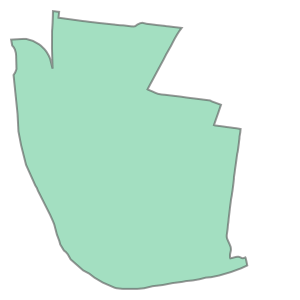

In [7]:
zone.loc[0, 'geometry']

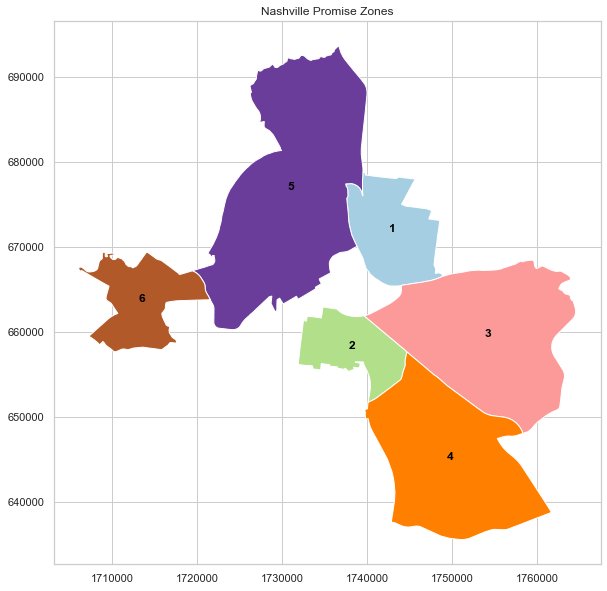

In [8]:
#Mapping and legend

#leg_kwds = {'title': 'Zone', 'loc': 'best', 
#            'bbox_to_anchor': (1, 1), 'ncol': 1}

#zone.plot(column = 'ZONE_ID', figsize=(12, 12), legend = True, legend_kwds = leg_kwds,cmap = 'Set2')
#plt.title('Nashville Promise Zones');
#plt.show()

fig, ax = plt.subplots(figsize = (10,10))
zone.plot(ax = ax, column = 'ZONE_ID', cmap = 'Paired')

for index, row in zone.iterrows():
    plt.annotate(s=row['ZONE_ID'], 
                 xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontweight = 'bold', color = 'black')
    
plt.title('Nashville Promise Zones');

# Count of Companies in File

In [9]:
counts_june = june_trip_df['companyName'].value_counts()
print(counts_june)

Lime             84728
Bird             55014
Lyft             37821
SPIN             14294
Bolt Mobility    10219
Gotcha            1803
JUMP              1748
Name: companyName, dtype: int64


# Adding Geometry Columns

In [10]:
#Add StartGeometry Column
june_trip_df['startGeometry'] = june_trip_df.apply(lambda x: Point((float(x.startLongitude), float(x.startLatitude))), axis=1)
june_trip_df.head()

,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,create_dt,startGeometry
0,2019-06-01 00:05:46.817000,Bird,BRD3572,PoweredSPI1T,4.0,328.084000,2019-06-01 00:00:00,00:02:18.203333,2019-06-01 00:00:00,00:06:16.406666,36.164400,-86.78070,36.163600,-86.780200,"[[36.164679,-86.781089],[36.163693,-86.78011],...",2019-06-02 05:30:19.960000,POINT (-86.7807 36.1644)
1,2019-06-01 00:05:46.817000,Bird,BRD3571,Powered2I3MS,5.0,4921.260000,2019-06-01 00:00:00,00:02:44.803333,2019-06-01 00:00:00,00:07:28.286666,36.175300,-86.79430,36.175300,-86.794300,"[[36.175367,-86.794232],[36.175367,-86.794232]...",2019-06-02 05:30:19.927000,POINT (-86.79430000000001 36.1753)
2,2019-06-01 00:09:54,Gotcha,GOT1,Powered327,12.0,12.426575,2019-06-01 00:00:00,00:09:56,2019-06-01 00:00:00,00:21:56,36.161501,-86.77601,36.152529,-86.783742,"[[""36.16149"",""-86.77605000000001""]]",2019-06-06 22:23:08.673000,POINT (-86.77601 36.161501)
3,2019-06-01 00:10:46.957000,Bird,BRD3610,Powered8U1A6,2.0,0.000000,2019-06-01 00:00:00,00:10:31.163333,2019-06-01 00:00:00,00:12:02.773333,36.164000,-86.78070,36.163100,-86.779700,"[[36.163168,-86.779639]]",2019-06-02 05:30:20.283000,POINT (-86.7807 36.164)
4,2019-06-01 00:10:46.957000,Bird,BRD3612,PoweredSPI1T,5.0,656.168000,2019-06-01 00:00:00,00:07:21.430000,2019-06-01 00:00:00,00:12:30.913333,36.165000,-86.77990,36.165900,-86.777800,"[[36.164951,-86.779836],[36.16494,-86.779456],...",2019-06-02 05:30:20.347000,POINT (-86.7799 36.165)


In [11]:
#Add EndGeometry Column
june_trip_df['endGeometry'] = june_trip_df.apply(lambda x: Point((float(x.endLongitude), float(x.endLatitude))), axis=1)
june_trip_df.head()

,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,create_dt,startGeometry,endGeometry
0,2019-06-01 00:05:46.817000,Bird,BRD3572,PoweredSPI1T,4.0,328.084000,2019-06-01 00:00:00,00:02:18.203333,2019-06-01 00:00:00,00:06:16.406666,36.164400,-86.78070,36.163600,-86.780200,"[[36.164679,-86.781089],[36.163693,-86.78011],...",2019-06-02 05:30:19.960000,POINT (-86.7807 36.1644),POINT (-86.78019999999999 36.1636)
1,2019-06-01 00:05:46.817000,Bird,BRD3571,Powered2I3MS,5.0,4921.260000,2019-06-01 00:00:00,00:02:44.803333,2019-06-01 00:00:00,00:07:28.286666,36.175300,-86.79430,36.175300,-86.794300,"[[36.175367,-86.794232],[36.175367,-86.794232]...",2019-06-02 05:30:19.927000,POINT (-86.79430000000001 36.1753),POINT (-86.79430000000001 36.1753)
2,2019-06-01 00:09:54,Gotcha,GOT1,Powered327,12.0,12.426575,2019-06-01 00:00:00,00:09:56,2019-06-01 00:00:00,00:21:56,36.161501,-86.77601,36.152529,-86.783742,"[[""36.16149"",""-86.77605000000001""]]",2019-06-06 22:23:08.673000,POINT (-86.77601 36.161501),POINT (-86.78374233333334 36.15252916666667)
3,2019-06-01 00:10:46.957000,Bird,BRD3610,Powered8U1A6,2.0,0.000000,2019-06-01 00:00:00,00:10:31.163333,2019-06-01 00:00:00,00:12:02.773333,36.164000,-86.78070,36.163100,-86.779700,"[[36.163168,-86.779639]]",2019-06-02 05:30:20.283000,POINT (-86.7807 36.164),POINT (-86.77970000000001 36.1631)
4,2019-06-01 00:10:46.957000,Bird,BRD3612,PoweredSPI1T,5.0,656.168000,2019-06-01 00:00:00,00:07:21.430000,2019-06-01 00:00:00,00:12:30.913333,36.165000,-86.77990,36.165900,-86.777800,"[[36.164951,-86.779836],[36.16494,-86.779456],...",2019-06-02 05:30:20.347000,POINT (-86.7799 36.165),POINT (-86.7778 36.1659)


In [12]:
#CSR check
zone.crs


{'init': 'epsg:2274'}

** following code translated from the GeoSpacial class work 'WeGo Bus Stops by District'**

stops = may_trip_df
districts = promise zones

In [13]:
#Joinging two files to one

#original code: districs_stops = gpd.sjoin(stops_geo, districs, op = 'within')
#original code: district stops

#trip_zone = gpd.sjoin(trip_geo, zone, op = 'within')
#trip_zone

# Convert Time & Date Columns to datetime formats

In [14]:
#Convert to Dates
june_trip_df['startDate']=pd.to_datetime(june_trip_df.startDate)
june_trip_df['endDate']=pd.to_datetime(june_trip_df.endDate)
june_trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205627 entries, 0 to 205626
Data columns (total 18 columns):
pubTimeStamp      205627 non-null object
companyName       205627 non-null object
tripRecordNum     205627 non-null object
sumdID            205627 non-null object
tripDuration      205627 non-null float64
tripDistance      205627 non-null float64
startDate         205627 non-null datetime64[ns]
startTime         205627 non-null object
endDate           205627 non-null datetime64[ns]
endTime           205627 non-null object
startLatitude     205627 non-null float64
startLongitude    205627 non-null float64
endLatitude       205627 non-null float64
endLongitude      205627 non-null float64
tripRoute         205627 non-null object
create_dt         205627 non-null object
startGeometry     205627 non-null object
endGeometry       205627 non-null object
dtypes: datetime64[ns](2), float64(6), object(10)
memory usage: 28.2+ MB


In [15]:
#Convert to Times
june_trip_df['startTime']=pd.to_datetime(june_trip_df.startTime)
june_trip_df['endTime']=pd.to_datetime(june_trip_df.endTime)
june_trip_df['pubTimeStamp']=pd.to_datetime(june_trip_df.pubTimeStamp)
june_trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205627 entries, 0 to 205626
Data columns (total 18 columns):
pubTimeStamp      205627 non-null datetime64[ns]
companyName       205627 non-null object
tripRecordNum     205627 non-null object
sumdID            205627 non-null object
tripDuration      205627 non-null float64
tripDistance      205627 non-null float64
startDate         205627 non-null datetime64[ns]
startTime         205627 non-null datetime64[ns]
endDate           205627 non-null datetime64[ns]
endTime           205627 non-null datetime64[ns]
startLatitude     205627 non-null float64
startLongitude    205627 non-null float64
endLatitude       205627 non-null float64
endLongitude      205627 non-null float64
tripRoute         205627 non-null object
create_dt         205627 non-null object
startGeometry     205627 non-null object
endGeometry       205627 non-null object
dtypes: datetime64[ns](5), float64(6), object(7)
memory usage: 28.2+ MB


# Save File

In [16]:
#save to CSV
june_trip_df.to_csv('Data/june_trip_geo.csv', index = False)

# Stats based on Days of Week, Hours of Day

In [17]:
#Total Trips by Day
june_trips_day = june_trip_df.groupby(june_trip_df['startDate'].dt.dayofweek).count().startTime

print(june_trips_day)

startDate
0    21467
1    19299
2    21497
3    21747
4    26327
5    52567
6    42723
Name: startTime, dtype: int64


Text(0, 0.5, 'Number of rides')

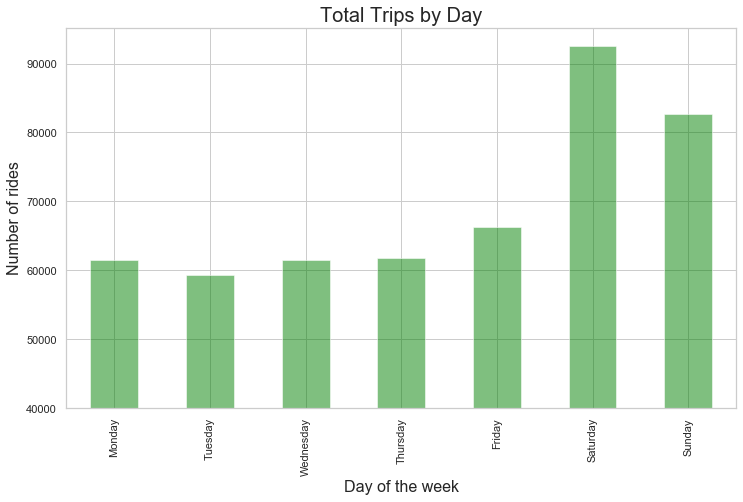

In [18]:
# Number of scooter per day of the week
june_trip_day = june_trip_df.groupby(june_trip_df['startDate'].dt.dayofweek).count().startDate

# Replace the day integers by day names.
june_trip_day.index=[calendar.day_name[x] for x in range(0,7)]

# plot accidents per day
Img2 = june_trip_day.plot(kind='bar',figsize=(12,7), color='green', alpha=0.5, bottom = 40000)

# title and x,y labels
plt.title('Total Trips by Day', fontsize=20)
plt.xlabel('Day of the week',fontsize=16)
plt.ylabel('Number of rides',fontsize=16)


Text(0, 0.5, 'Number of rides')

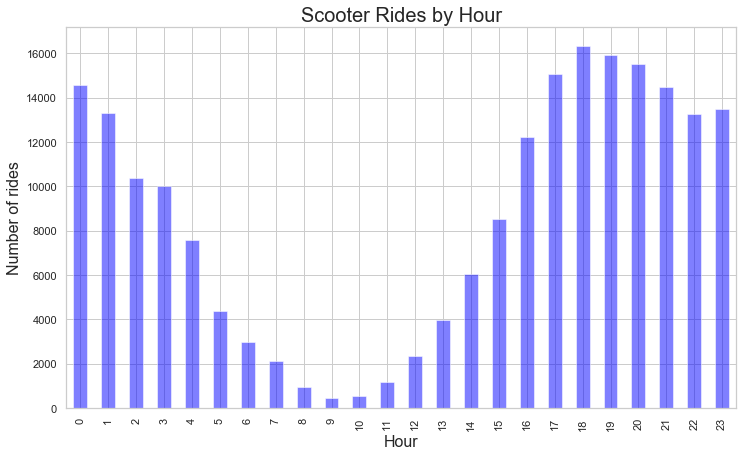

In [19]:
# Number of trips per hour
june_trip_hour = june_trip_df.groupby(june_trip_df['startTime'].dt.hour).count().startTime

# plot trips per hour
june_trip_hour.plot(kind='bar',figsize=(12,7), color='blue', alpha=0.5, bottom = 0)

# title and x,y labels
plt.title('Scooter Rides by Hour', fontsize=20)
plt.xlabel('Hour',fontsize=16)
plt.ylabel('Number of rides',fontsize=16)



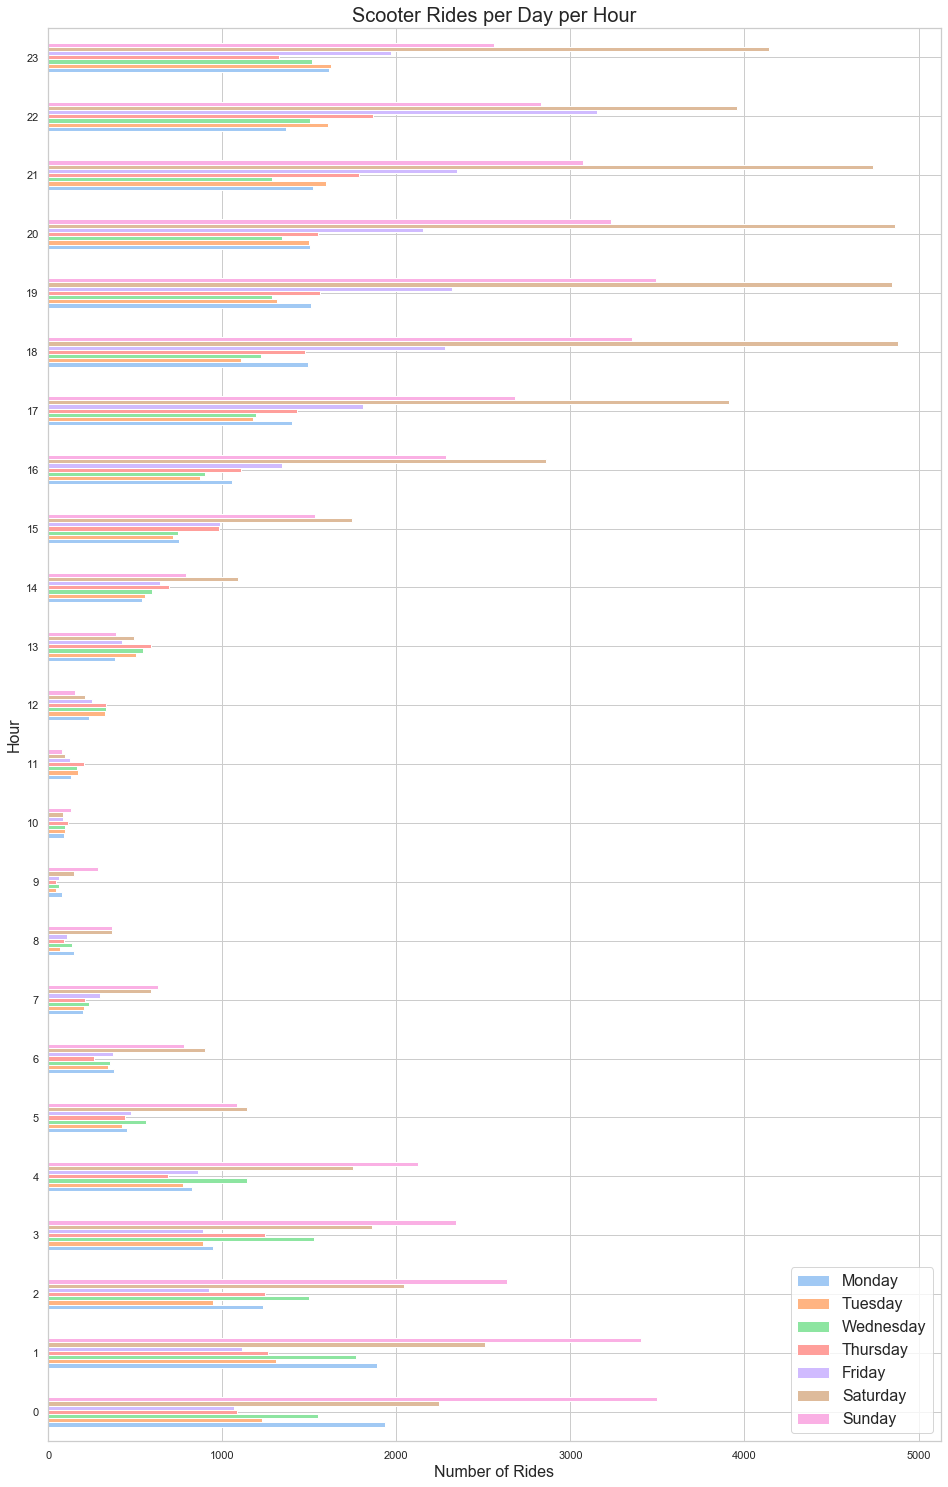

In [20]:
# Number of  Trips per hour and day
trips_hour_day = june_trip_df.groupby([june_trip_df['pubTimeStamp'].dt.hour.rename('hour'),june_trip_df['pubTimeStamp'].dt.dayofweek.rename('day')]).count().pubTimeStamp

trips_hour_day.unstack().plot(kind='barh', figsize=(16,26))

# title and x,y labels
plt.legend(labels=[calendar.day_name[x] for x in range(0,7)],fontsize=16)
plt.title('Scooter Rides per Day per Hour',fontsize=20)
plt.xlabel('Number of Rides',fontsize=16)
plt.ylabel('Hour',fontsize=16);

# Number of Rides per Scooter

In [21]:
#Count of rides on each scooter
counts_scooters = june_trip_df['sumdID'].value_counts()
print(counts_scooters)

Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2     1308
PoweredUNKNOWN                                  1120
PoweredSQWMJWTIGM6DS                             158
PoweredOQ3DRY64KZBYS                             158
Powered3ZPCHCTLNK2WR                             144
PoweredOQYNOUBQPNGUS                             139
Powered5QBZSLFMLMLQU                             135
PoweredSJTYATG4FVICD                             133
Powered7UN7P27A5HR5H                             133
PoweredOWWGOR5KA6ZLV                             133
Powered57NZJYNTN4KT4                             132
PoweredMSUABN2YMDFWK                             132
PoweredZ4WPML62Z56WJ                             131
Powered2WZ4JPUCZFXN5                             131
Powered3WD63MPJQERKZ                             131
PoweredLWRRVABRUKJZZ                             130
PoweredFOC4N7EUJUNHM                             130
PoweredIFJIBG3QHYXWB                             130
Powered2ZW44BAIKSF7F                          

# Count Number of Rides per Day

In [22]:
#Count of rides on each scooter
counts_startDate = june_trip_df['startDate'].value_counts()
print(counts_startDate)

2019-06-08    13674
2019-06-01    12673
2019-06-15    11199
2019-06-02    10260
2019-06-09     9965
2019-06-16     9406
2019-06-29     8439
2019-06-14     8345
2019-06-30     7188
2019-06-06     7151
2019-06-22     6582
2019-06-03     6325
2019-06-21     6228
2019-06-05     6143
2019-06-28     6003
2019-06-23     5904
2019-06-17     5895
2019-06-13     5814
2019-06-10     5814
2019-06-07     5751
2019-06-04     5709
2019-06-12     5389
2019-06-19     5313
2019-06-11     5087
2019-06-25     4851
2019-06-26     4652
2019-06-20     4441
2019-06-27     4341
2019-06-18     3652
2019-06-24     3433
Name: startDate, dtype: int64


The busiest day of the month was 5/26/2019

In [23]:
#Subsetting 5/26/19 by Active Scooters

#day = (june_trip_df['startDate'] == '2019-05-26')
#busyday = june_trip_df.loc[day]
#busyday.head(2)

Several entries show trips where a beginning point and end point are the same. Due to this, trips without a change in geography will be considered inactive.

# Filtering DataFrame to Only Active Scooters 

In [24]:
#creating an alternative df to later edit
active_df = june_trip_df

In [25]:
#populate the Low Rides df based on the a specified date
    
#for index, row in active_df.iterrows():
#    if row['startGeometry'] == row['endGeometry']:
#       active_df.drop(index, inplace=True)
    
#active_df.startgeometry.value_count()

In [26]:
#filter down to trips where distance was recorded
active_df = active_df[active_df.startGeometry != active_df.endGeometry]

# Remove trips over 24 hrs

In [27]:
#filter previous list to those under 24 hour trips
active_df = active_df[active_df.tripDuration <= 1440.0000]

In [28]:
# Count of rides meeting 24hrs or less 
counts_co1 = active_df['companyName'].value_counts()
counts_co1

Lime             83946
Bird             50371
Lyft             37690
SPIN             13979
Bolt Mobility     7057
Gotcha            1778
JUMP              1695
Name: companyName, dtype: int64

# Remove trips under 1 minute

In [29]:
#filter previous list to those under 1 minute 
active_df = active_df[active_df.tripDuration >= 1.0000]

In [30]:
counts_co2 = active_df['companyName'].value_counts()
counts_co2

Lime             83913
Bird             50128
Lyft             36294
SPIN             13979
Bolt Mobility     7057
Gotcha            1778
JUMP              1695
Name: companyName, dtype: int64

# Filter the Active DataFrame to Those Traveled 3 Meters or More

In [31]:
#filter down the previously filtered list to trips that traveled 3 meters or more

#file provides distance in feet. 1 meter = 3.2 feet
active_df[active_df.tripDistance >= 9.83]

,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,create_dt,startGeometry,endGeometry
0,2019-06-01 00:05:46.817,Bird,BRD3572,PoweredSPI1T,4.000000,328.084000,2019-06-01,2019-09-15 00:02:18.203333,2019-06-01,2019-09-15 00:06:16.406666,36.164400,-86.780700,36.163600,-86.780200,"[[36.164679,-86.781089],[36.163693,-86.78011],...",2019-06-02 05:30:19.960000,POINT (-86.7807 36.1644),POINT (-86.78019999999999 36.1636)
2,2019-06-01 00:09:54.000,Gotcha,GOT1,Powered327,12.000000,12.426575,2019-06-01,2019-09-15 00:09:56.000000,2019-06-01,2019-09-15 00:21:56.000000,36.161501,-86.776010,36.152529,-86.783742,"[[""36.16149"",""-86.77605000000001""]]",2019-06-06 22:23:08.673000,POINT (-86.77601 36.161501),POINT (-86.78374233333334 36.15252916666667)
4,2019-06-01 00:10:46.957,Bird,BRD3612,PoweredSPI1T,5.000000,656.168000,2019-06-01,2019-09-15 00:07:21.430000,2019-06-01,2019-09-15 00:12:30.913333,36.165000,-86.779900,36.165900,-86.777800,"[[36.164951,-86.779836],[36.16494,-86.779456],...",2019-06-02 05:30:20.347000,POINT (-86.7799 36.165),POINT (-86.7778 36.1659)
6,2019-06-01 00:10:46.957,Bird,BRD3614,Powered1PQQB,6.000000,2296.588000,2019-06-01,2019-09-15 00:06:11.906666,2019-06-01,2019-09-15 00:12:34.403333,36.151600,-86.802100,36.151400,-86.802000,"[[36.151438,-86.801898],[36.151184,-86.802086]...",2019-06-02 05:30:20.410000,POINT (-86.8021 36.1516),POINT (-86.80200000000001 36.1514)
7,2019-06-01 00:10:46.957,Bird,BRD3613,PoweredEVLBD,5.000000,2956.036840,2019-06-01,2019-09-15 00:06:57.423333,2019-06-01,2019-09-15 00:12:24.340000,36.165400,-86.779700,36.168800,-86.772400,"[[36.165417,-86.779979],[36.164841,-86.781458]...",2019-06-02 05:30:20.380000,POINT (-86.77970000000001 36.1654),POINT (-86.7724 36.1688)
9,2019-06-01 00:12:04.230,SPIN,SPI5,Powered5000596,6.000000,479.002640,2019-06-01,2019-09-15 00:05:45.000000,2019-06-01,2019-09-15 00:11:26.000000,36.151341,-86.799770,36.150363,-86.800862,"[[36.150363247404989,-86.800861925250217],[36....",2019-06-02 09:06:15.830000,POINT (-86.79977009766304 36.15134068198822),POINT (-86.8008619252502 36.15036324740498)
10,2019-06-01 00:15:47.313,Bird,BRD3645,PoweredUKG5P,3.000000,656.168000,2019-06-01,2019-09-15 00:14:17.646666,2019-06-01,2019-09-15 00:17:46.270000,36.181300,-86.786400,36.181600,-86.786200,"[[36.181382,-86.786487],[36.1813,-86.786832],[...",2019-06-02 05:30:20.807000,POINT (-86.7864 36.1813),POINT (-86.78619999999999 36.1816)
11,2019-06-01 00:15:47.313,Bird,BRD3654,Powered23WB2,16.000000,10498.688000,2019-06-01,2019-09-15 00:01:20.733333,2019-06-01,2019-09-15 00:17:22.206666,36.176800,-86.750200,36.164900,-86.776300,"[[36.176925,-86.750167],[36.176859,-86.750023]...",2019-06-02 05:30:21.100000,POINT (-86.75020000000001 36.1768),POINT (-86.77630000000001 36.1649)
12,2019-06-01 00:15:47.313,Bird,BRD3655,PoweredCBZVU,16.000000,10498.688000,2019-06-01,2019-09-15 00:00:52.726666,2019-06-01,2019-09-15 00:17:17.860000,36.176800,-86.750200,36.168700,-86.773500,"[[36.176928,-86.750184],[36.176928,-86.750184]...",2019-06-02 05:30:21.133000,POINT (-86.75020000000001 36.1768),POINT (-86.7735 36.1687)
13,2019-06-01 00:15:47.313,Bird,BRD3651,PoweredIIMK1,8.000000,1968.504000,2019-06-01,2019-09-15 00:09:10.210000,2019-06-01,2019-09-15 00:17:18.153333,36.158300,-86.776800,36.161700,-86.772800,"[[36.15879,-86.777046],[36.159548,-86.776752],...",2019-06-02 05:30:21,POINT (-86.77679999999999 36.1583),POINT (-86.7728 36.1617)


In [32]:
active_df.tail(1)

,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,create_dt,startGeometry,endGeometry
205626,2019-07-01 19:58:07,JUMP,JMP50,Powered1b56f557-adce-5c68-a98b-ab1ef41c7dcc,1440.0,32472.0,2019-06-29,2019-09-15 15:55:36,2019-07-01,2019-09-15 14:03:58,36.164547,-86.77692,36.18017,-86.748,"[[""36.164546"",""-86.776913""],[""36.164546"",""-86....",2019-07-02 07:58:39.893000,POINT (-86.77692 36.164547),POINT (-86.748 36.18017)


# Filtering to Scooters w/ 90 trips per month (by DSpau)

In [33]:
#making list of scooter ids and times appeared.
Group1 = active_df.groupby(active_df.sumdID.tolist(),as_index=False).size()
print(Group1)

Powered-017d3133-f14a-2b83-ee4f-d777e7c5b619    24
Powered-01a24436-0315-e1bb-7ce0-d081d05dff7d    19
Powered-03be23ca-d43b-222f-be54-e44b5b4690df    29
Powered-046201fb-6532-1f37-6334-3612fb1e61f7    32
Powered-0479bb84-afbd-0426-f1c4-df628542a88c    41
Powered-0540c92c-0907-dafa-b19f-011495068ec5    19
Powered-0555d61d-1c59-4219-edf3-0f00e286629a    25
Powered-058d0498-dac4-437f-5a45-c951da4040a2    19
Powered-05fedb39-a00f-a5e0-2219-8c3c7dd1b80e    22
Powered-079ce993-98bd-417a-acfe-76e2861ebf9b    23
Powered-08505f68-1f44-5d79-48c5-1370977e40d5    12
Powered-09c75f98-6492-9d35-12e4-c5649cebf403    30
Powered-0a8e2ca5-5eae-511e-ef0d-74d582fa8cee    14
Powered-0ac70fa5-9f26-e69b-ca7a-9803d2aa1535    17
Powered-0b4a127c-3c2a-a917-cbf4-ccb17b8604f6    27
Powered-0d5cbe57-9da1-9fad-e31c-4e33282a1efd    19
Powered-0e3d7343-0a27-2854-2dbc-23166bea8c8c    25
Powered-0e66b4be-c897-5140-f34c-b78d3beea648    22
Powered-0ef64718-9c36-353e-8bf0-39719364d924    27
Powered-0f344f74-7253-b66b-31b5

In [34]:
Group1.to_csv('./Data/June_Active_Trip_Counter.csv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [35]:
col_Names=["sumdID", "Trips"]
Group2CSV= pd.read_csv("./Data/June_Active_Trip_Counter.csv",names=col_Names)

In [36]:
Group2CSV

,sumdID,Trips
0,Powered-017d3133-f14a-2b83-ee4f-d777e7c5b619,24
1,Powered-01a24436-0315-e1bb-7ce0-d081d05dff7d,19
2,Powered-03be23ca-d43b-222f-be54-e44b5b4690df,29
3,Powered-046201fb-6532-1f37-6334-3612fb1e61f7,32
4,Powered-0479bb84-afbd-0426-f1c4-df628542a88c,41
5,Powered-0540c92c-0907-dafa-b19f-011495068ec5,19
6,Powered-0555d61d-1c59-4219-edf3-0f00e286629a,25
7,Powered-058d0498-dac4-437f-5a45-c951da4040a2,19
8,Powered-05fedb39-a00f-a5e0-2219-8c3c7dd1b80e,22
9,Powered-079ce993-98bd-417a-acfe-76e2861ebf9b,23


In [37]:
#filtering down the previously filtered database to those that could have been riden3 times a day.
Trips_df = Group2CSV[Group2CSV.Trips >= 90]

In [38]:
Trips_df

,sumdID,Trips
911,Powered25PS3VEKPY4BH,109
1050,Powered2JKPJFIDOWM5I,125
1068,Powered2OFHK7WJJGPSG,90
1071,Powered2PIIROGN76GLF,114
1078,Powered2RD2NBC3IK74F,105
1092,Powered2UOBTBJ3PG3YV,91
1104,Powered2WZ4JPUCZFXN5,130
1112,Powered2ZW44BAIKSF7F,129
1388,Powered3HT5LVR5RZDMW,119
1389,Powered3HZ3AWQT4GVKE,92


In [39]:
#Most Used Scooter:
A = Trips_df.Trips.max()
B = Trips_df.sumdID.max()

print(A)
print(B)

1268
Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2


In [40]:
Most_Used = Trips_df[Trips_df.Trips == 1268]
Most_Used

,sumdID,Trips
6683,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,1268


In [41]:
FilteredTrips = active_df[active_df['sumdID'].isin(Trips_df.sumdID)]
FilteredTrips

,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,create_dt,startGeometry,endGeometry
157,2019-06-01 00:50:25.727,Lime,LIM96,PoweredIUNYIXFUM3M7P,12.050000,4340.498400,2019-06-01,2019-09-15 00:06:50,2019-06-01,2019-09-15 00:18:53,36.160903,-86.781266,36.171020,-86.785103,"[[36.16212,-86.77963],[36.1629,-86.77826999999...",2019-06-02 07:33:53.410000,POINT (-86.781266 36.160903),POINT (-86.78510300000001 36.17102)
158,2019-06-01 00:50:25.730,Lime,LIM98,PoweredAE5QKKSVXWKNP,9.083333,5551.113600,2019-06-01,2019-09-15 00:10:07,2019-06-01,2019-09-15 00:19:12,36.177593,-86.786881,36.165167,-86.781482,"[[36.17759,-86.78688],[36.17754,-86.78697],[36...",2019-06-02 07:33:53.473000,POINT (-86.78688099999999 36.177593),POINT (-86.781482 36.165167)
168,2019-06-01 00:50:25.740,Lime,LIM119,PoweredIFJIBG3QHYXWB,10.533333,0.000000,2019-06-01,2019-09-15 00:12:29,2019-06-01,2019-09-15 00:23:01,36.143047,-86.806264,36.143191,-86.810043,"[[36.14699,-86.79278]]",2019-06-02 07:33:54.630000,POINT (-86.806264 36.143047),POINT (-86.81004299999999 36.143191)
177,2019-06-01 00:50:25.747,Lime,LIM127,PoweredLXV7RJSLHE56P,6.516667,1732.262400,2019-06-01,2019-09-15 00:17:22,2019-06-01,2019-09-15 00:23:53,36.145477,-86.812484,36.145991,-86.813202,"[[36.14624,-86.81306],[36.14666,-86.8133099999...",2019-06-02 07:33:54.890000,POINT (-86.812484 36.145477),POINT (-86.813202 36.145991)
180,2019-06-01 00:50:25.753,Lime,LIM138,PoweredQQOLTIYF2NHPZ,6.716667,5075.397600,2019-06-01,2019-09-15 00:19:24,2019-06-01,2019-09-15 00:26:07,36.137622,-86.800460,36.151517,-86.798091,"[[36.13784,-86.80084],[36.13939,-86.8004],[36....",2019-06-02 07:33:55.280000,POINT (-86.80046 36.137622),POINT (-86.798091 36.151517)
181,2019-06-01 00:50:25.753,Lime,LIM142,PoweredEL6C64ISVQT6R,7.983333,4445.484000,2019-06-01,2019-09-15 00:19:20,2019-06-01,2019-09-15 00:27:19,36.174217,-86.785619,36.165535,-86.778770,"[[36.17422,-86.78562],[36.17422,-86.7858699999...",2019-06-02 07:33:55.410000,POINT (-86.785619 36.174217),POINT (-86.77876999999999 36.165535)
183,2019-06-01 00:50:25.757,Lime,LIM143,PoweredIRNTIV6Q7DQZ5,14.183333,6532.072800,2019-06-01,2019-09-15 00:13:13,2019-06-01,2019-09-15 00:27:24,36.152575,-86.790419,36.160912,-86.772881,"[[36.15258,-86.79042],[36.153,-86.789949999999...",2019-06-02 07:33:55.443000,POINT (-86.790419 36.152575),POINT (-86.772881 36.160912)
198,2019-06-01 00:50:25.773,Lime,LIM184,PoweredFOC4N7EUJUNHM,16.966667,7296.499200,2019-06-01,2019-09-15 00:20:58,2019-06-01,2019-09-15 00:37:56,36.128256,-86.777750,36.123416,-86.789892,"[[36.12826,-86.77775],[36.12836,-86.77767],[36...",2019-06-02 07:33:56.950000,POINT (-86.77775 36.128256),POINT (-86.78989199999999 36.123416)
200,2019-06-01 00:50:25.773,Lime,LIM181,Powered2UOBTBJ3PG3YV,8.583333,7204.636800,2019-06-01,2019-09-15 00:28:39,2019-06-01,2019-09-15 00:37:14,36.143884,-86.788520,36.154691,-86.777144,"[[36.14388,-86.78852],[36.144000000000005,-86....",2019-06-02 07:33:56.853000,POINT (-86.78852000000001 36.143884),POINT (-86.77714400000001 36.154691)
202,2019-06-01 00:50:25.773,Lime,LIM180,PoweredAE5QKKSVXWKNP,3.800000,2463.880800,2019-06-01,2019-09-15 00:33:17,2019-06-01,2019-09-15 00:37:05,36.163188,-86.780263,36.170263,-86.784670,"[[36.16415,-86.78111],[36.16676,-86.78269],[36...",2019-06-02 07:33:56.820000,POINT (-86.78026300000001 36.163188),POINT (-86.78467000000001 36.170263)


In [42]:
counts_co1 = FilteredTrips['companyName'].value_counts()
print(counts_co1)

Lime    28211
JUMP     1268
Lyft       91
Name: companyName, dtype: int64


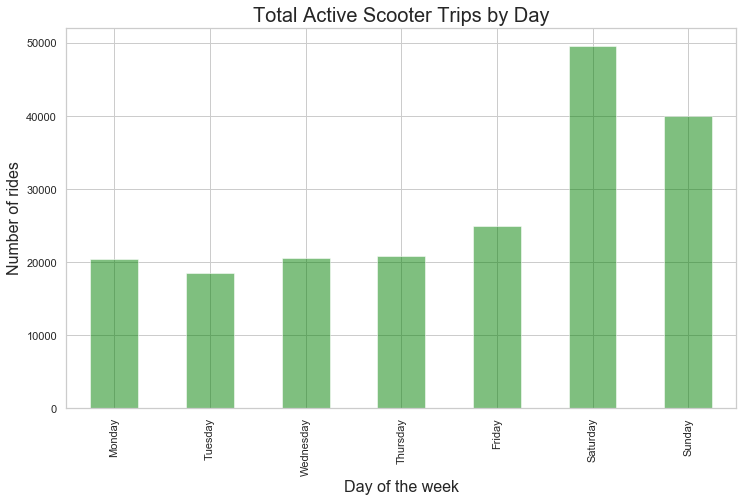

In [43]:
# Number of scooter per day of the week
june_active = active_df.groupby(active_df['startDate'].dt.dayofweek).count().startDate

# Replace the day integers by day names.
june_active.index=[calendar.day_name[x] for x in range(0,7)]

# plot accidents per day
june_active.plot(kind='bar',figsize=(12,7), color='green', alpha=0.5, bottom = 0)

# title and x,y labels
plt.title('Total Active Scooter Trips by Day', fontsize=20)
plt.xlabel('Day of the week',fontsize=16)
plt.ylabel('Number of rides',fontsize=16);

# JUMP Scooter w/ excessive rides data

In [44]:
#view JUMP scooter w/ 600 rides
JUMP_June = FilteredTrips[FilteredTrips.sumdID == 'Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2']
JUMP_June

,pubTimeStamp,companyName,tripRecordNum,sumdID,tripDuration,tripDistance,startDate,startTime,endDate,endTime,startLatitude,startLongitude,endLatitude,endLongitude,tripRoute,create_dt,startGeometry,endGeometry
81384,2019-06-10 18:56:13,JUMP,JMP2,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,3.228833,528.0,2019-06-10,2019-09-15 13:55:46,2019-06-10,2019-09-15 13:59:00,36.154133,-86.784080,36.154457,-86.785900,"[[""36.154133"",""-86.784078""],[""36.154133"",""-86....",2019-06-11 07:12:12.610000,POINT (-86.78408 36.154133),POINT (-86.7859 36.154457)
85029,2019-06-11 07:50:56,JUMP,JMP20,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,6.876867,1900.8,2019-06-11,2019-09-15 01:50:35,2019-06-11,2019-09-15 01:57:28,36.161880,-86.777780,36.163807,-86.778940,"[[""36.16188"",""-86.777775""],[""36.16188"",""-86.77...",2019-06-12 07:14:00.957000,POINT (-86.77778000000001 36.16188),POINT (-86.77894000000001 36.163807)
85030,2019-06-11 07:50:56,JUMP,JMP21,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,9.020367,2904.0,2019-06-11,2019-09-15 01:52:08,2019-06-11,2019-09-15 02:01:10,36.162930,-86.776240,36.157124,-86.780980,"[[""36.162928"",""-86.776241""],[""36.162928"",""-86....",2019-06-12 07:14:00.993000,POINT (-86.77624 36.16293),POINT (-86.78098 36.157124)
85031,2019-06-11 07:50:56,JUMP,JMP22,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,3.628050,686.4,2019-06-11,2019-09-15 02:03:56,2019-06-11,2019-09-15 02:07:34,36.175200,-86.788060,36.174450,-86.786420,"[[""36.1752"",""-86.78806""],[""36.175201"",""-86.788...",2019-06-12 07:14:01.027000,POINT (-86.78806 36.1752),POINT (-86.78642000000001 36.17445)
85032,2019-06-11 07:50:56,JUMP,JMP23,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,24.942583,5808.0,2019-06-11,2019-09-15 02:01:26,2019-06-11,2019-09-15 02:26:23,36.146250,-86.799470,36.147650,-86.800160,"[[""36.14623"",""-86.799606""],[""36.146001"",""-86.7...",2019-06-12 07:14:01.060000,POINT (-86.79947 36.14625),POINT (-86.80016000000001 36.14765)
85033,2019-06-11 07:50:56,JUMP,JMP27,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,13.601434,7867.2,2019-06-11,2019-09-15 02:39:45,2019-06-11,2019-09-15 02:53:21,36.164104,-86.779970,36.176693,-86.776330,"[[""36.164103"",""-86.779968""],[""36.164103"",""-86....",2019-06-12 07:14:01.200000,POINT (-86.77997000000001 36.164104),POINT (-86.77633 36.176693)
85034,2019-06-11 07:50:56,JUMP,JMP29,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,2.418783,422.4,2019-06-11,2019-09-15 03:14:59,2019-06-11,2019-09-15 03:17:24,36.161650,-86.777890,36.162710,-86.777320,"[[""36.161651"",""-86.77789""],[""36.16271"",""-86.77...",2019-06-12 07:14:01.267000,POINT (-86.77789 36.16165),POINT (-86.77732 36.16271)
85035,2019-06-11 07:50:56,JUMP,JMP28,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,18.223516,6072.0,2019-06-11,2019-09-15 02:49:02,2019-06-11,2019-09-15 03:07:15,36.153767,-86.797950,36.158924,-86.782300,"[[""36.154358"",""-86.798495""],[""36.154403"",""-86....",2019-06-12 07:14:01.233000,POINT (-86.79795 36.153767),POINT (-86.78230000000001 36.158924)
85037,2019-06-11 07:50:56,JUMP,JMP26,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,5.008383,2745.6,2019-06-11,2019-09-15 02:36:57,2019-06-11,2019-09-15 02:41:57,36.177307,-86.792760,36.174625,-86.785790,"[[""36.17731"",""-86.79268""],[""36.177341"",""-86.79...",2019-06-12 07:14:01.130000,POINT (-86.79276 36.177307),POINT (-86.78579000000001 36.174625)
85038,2019-06-11 07:50:56,JUMP,JMP25,Poweredb671ffe4-2bca-5880-98ec-d36f65aa11a2,5.639550,2798.4,2019-06-11,2019-09-15 02:36:18,2019-06-11,2019-09-15 02:41:57,36.177326,-86.792820,36.174683,-86.785480,"[[""36.177326"",""-86.79282""],[""36.177285"",""-86.7...",2019-06-12 07:14:01.163000,POINT (-86.79282000000001 36.177326),POINT (-86.78548000000001 36.174683)


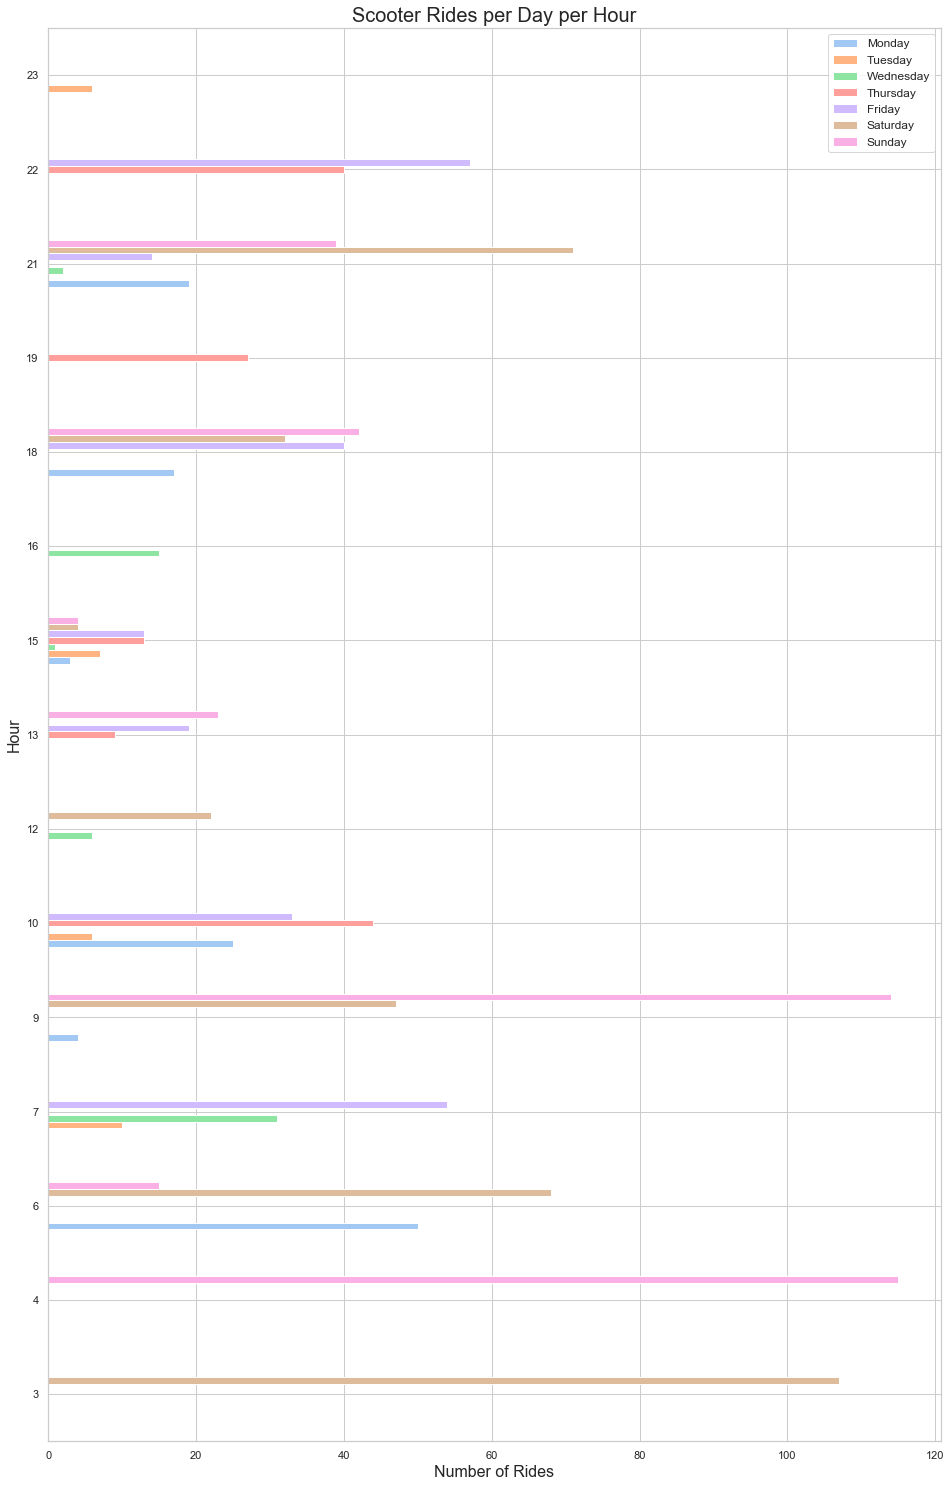

In [45]:
# Number of  Trips per hour and day - Jump Scooter
trips_hour_day1 = JUMP_June.groupby([JUMP_June['pubTimeStamp'].dt.hour.rename('hour'),JUMP_June['pubTimeStamp'].dt.dayofweek.rename('day')]).count().pubTimeStamp

trips_hour_day1.unstack().plot(kind='barh', figsize=(16,26))

# title and x,y labels
plt.legend(labels=[calendar.day_name[x] for x in range(0,7)],fontsize=12)
plt.title('Scooter Rides per Day per Hour',fontsize=20)
plt.xlabel('Number of Rides',fontsize=16)
plt.ylabel('Hour',fontsize=16);

In [46]:
Rides = JUMP_June.groupby(JUMP_June['pubTimeStamp'].dt.date).count().pubTimeStamp
Rides

pubTimeStamp
2019-06-10      1
2019-06-11     23
2019-06-12     48
2019-06-13    133
2019-06-14    230
2019-06-15    351
2019-06-16    352
2019-06-17    117
2019-06-18      6
2019-06-19      7
Name: pubTimeStamp, dtype: int64

Text(0.5, 0, 'date')

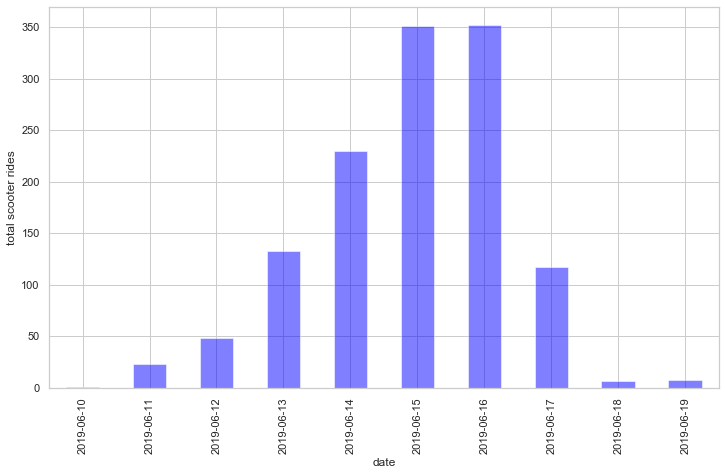

In [47]:
Rides.plot(kind='bar',figsize=(12,7), color='blue', alpha=0.5)
plt.ylabel('total scooter rides', fontsize=12)
plt.xlabel ('date', fontsize=12)

In [48]:
#JUMP_5_17 = JUMP_June[JUMP_May.startDate == '2019-05-17']


#save to CSV
#JUMP_5_17.to_csv('Data/JUMP_May5_17.csv', index = False)

In [49]:
#JUMP_5_17


In [50]:
#JUMP_5_17 = JUMP_May[JUMP_May.startDate == '2019-05-17']

In [51]:
#JUMP_May.info()

# Subsetting to specific time frame

In [52]:
#Jump_Time = JUMP_5_17[(JUMP_5_17.startTime >= '2019-09-12 04:00:00') & (JUMP_5_17.startTime <= '2019-09-12 04:15:00')]
#Jump_Time['geo'] = JUMP_5_17.apply(lambda x: list((float(x.startLatitude), float(x.startLongitude))), axis=1)
#for i in Jump_Time['geo']:
 #   print(i[0], i[1])

In [53]:
starts = Jump_Time


NameError: name 'Jump_Time' is not defined

In [ ]:
#locations = starts[['startLatitude', 'startLongitude']]
#locationlist = locations.values.tolist()
#len(locationlist)
#locationlist[1]

In [ ]:
#nashv_map = folium.Map(location=[36.174465, -86.767960], zoom_start=12)
#for point in range(0, len(locationlist)):
 #   folium.Marker(locationlist[point], popup=starts['sumdID'][point]).add_to(nashv_map)
#nashv_map

# Mapping

In [ ]:
#create our map of Antioch and show it
#map_nash = folium.Map(location=[36.174465, -86.767960], zoom_start=12)
#map_nash

In [ ]:

#JUMP = gpd.GeoDataFrame(Jump_Time, geometry = 'startGeometry')


#JUMPS.to_file("./Data/JUMP_5_17.geojson", driver='GeoJSON')

In [ ]:
#for geo in Jump_Time['geo']:
#   folium.features.Circle([geo[1], geo[0]], radius=4, color='darkslateblue', opacity=0.5).add_to(map_nash)

#map_nash

In [ ]:
#draw our neighborhood: Urban Residents

#nashville_map = folium.Map(location=[36.174465, -86.767960], zoom_start=12)

#folium.GeoJson(JUMP[['startGeometry']].to_json())

#points = folium.features.GeoJson(JUMP[['startGeometry']].to_json())
#ends = folium.features.GeoJson(JUMPS[['endGeometry']].to_json())

#nashville_map.add_child(points) 

#nashville_map


nashville_map = folium.Map(location=[36.174465, -86.767960], zoom_start=12)


for geo in Jump_Time['geo']:
    folium.features.Circle([geo[1], geo[0]],
                               radius=4,
                               color='darkslateblue',
                               opacity=0.5
                               ).add_to(nashville_map)


nashville_map

# Spare Code

HeatMap code:

Nashville_map = folium.Map(location=[36.1619178,-86.8213942], zoom_start=12)

hour_list = [[] for _ in range(24)]
for lat,log,hour in zip(bolt_june_df.latitude,bolt_june_df.longitude,bolt_june_df.pubdatetime.dt.hour):
    hour_list[hour].append([lat,log]) 


index = [str(i)+' Hours' for i in range(24)]


HeatMapWithTime(hour_list, index).add_to(Nashville_map)

Nashville_map